In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
from sklearn import tree, svm, datasets, metrics, preprocessing
from sklearn.model_selection import train_test_split,StratifiedKFold, ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from utilities import plot_2d_data, plot_2d_classifier, plot_confusionmatrix
from utilities import learning_curve_model, validation_curve_model, plot_learning_curve
from scipy import stats
import seaborn as sns
import os
import timeit

from utilities import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

In [51]:
data = pd.read_csv("./data/winequality-white.csv")
data.shape

(4898, 12)

In [52]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [53]:
data_X = data.drop(columns = ['quality'], axis=1)
data_y = data['quality']
# data_X = preprocessing.normalize(data_X, axis=0)
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=100)

In [54]:
sm = SMOTE(k_neighbors=1, random_state=42)
train_res_X, train_res_y = sm.fit_sample(train_X, train_y.ravel())

In [55]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

In [56]:
dtc = tree.DecisionTreeClassifier(random_state=100)
dtc.fit(train_res_X, train_res_y)

DecisionTreeClassifier(random_state=100)

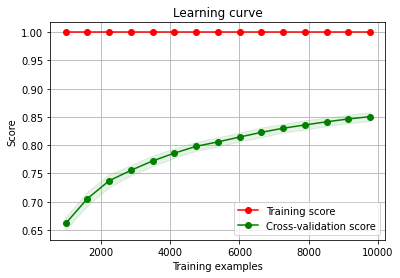

In [19]:
train_size=np.linspace(.1, 1.0, 15)
learning_curve_model(train_res_X, train_res_y, dtc, cv, train_size)
plt.show()

In [20]:
predict_y_train = dtc.predict(train_res_X)
predict_y = dtc.predict(test_X)
print(f"Training accuracy score: {100* accuracy_score(train_res_y, predict_y_train)}%")
print(f"Testing accuracy Score: {100* accuracy_score(test_y, predict_y)}%")

Training accuracy score: 100.0%
Testing accuracy Score: 60.30612244897959%


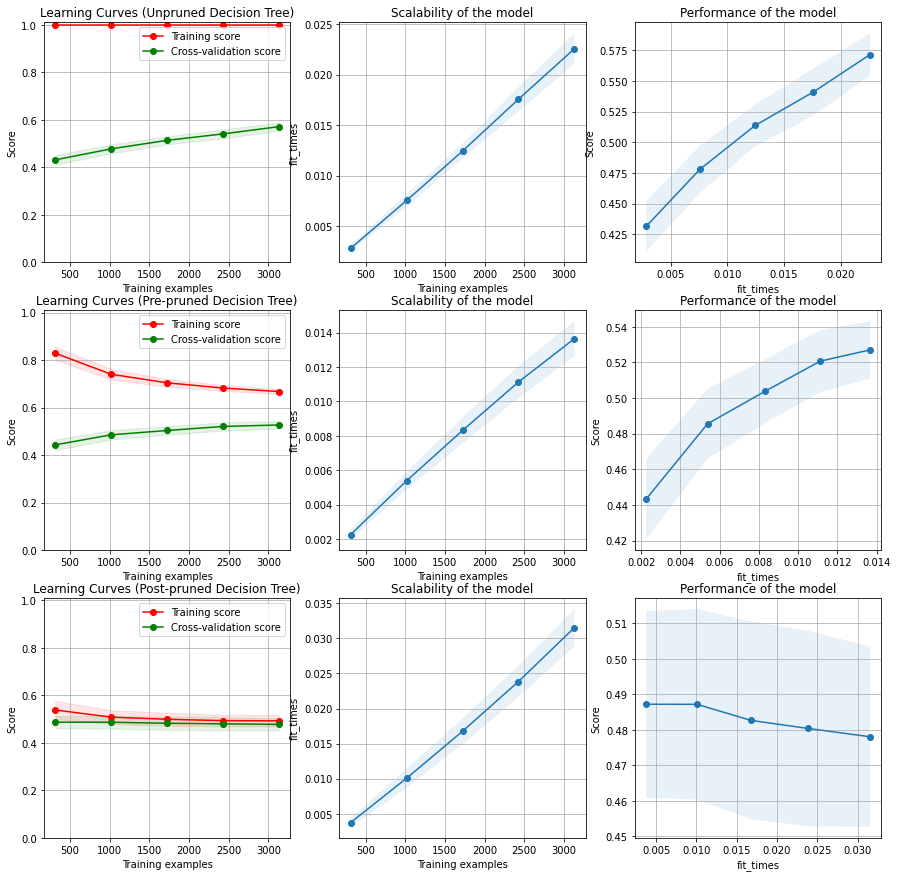

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

title = "Learning Curves (Unpruned Decision Tree)"
dtc = tree.DecisionTreeClassifier(random_state=100)
plot_learning_curve(dtc, title, train_X, train_y, axes=axes[0, :], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves (Pre-pruned Decision Tree)"
dtc_pre = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=3)
plot_learning_curve(dtc_pre, title, train_X, train_y, axes=axes[1,:], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves (Post-pruned Decision Tree)"
dtc_post = tree.DecisionTreeClassifier(ccp_alpha=0.018, random_state=100)
plot_learning_curve(dtc_post, title, train_X, train_y, axes=axes[2,:], ylim=(0, 1.01), cv=cv, n_jobs=4)


plt.show()

### Neural Network

In [ ]:
sc = StandardScaler() 
scaled_train_X = sc.fit_transform(train_X)
scaled_test_X = sc.transform(test_X)

In [ ]:
mlp = MLPClassifier(max_iter=5000, random_state=18, early_stopping=True)
param_list = {"hidden_layer_sizes": [(1,),(5,),(10,)], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00001, 0.00005,0.0005]}

gcv = GridSearchCV(estimator=mlp, param_grid=param_list)
gcv.fit(scaled_train_X, train_y)

In [ ]:
print('Best parameters found:\n', gcv.best_params_, gcv.best_score_)

In [ ]:
# title = "Learning Curves (5 layer MLP)"
#clf1 = MLPClassifier(hidden_layer_sizes=(11,8), solver='lbfgs', max_iter=10000, random_state=18, early_stopping=True)
#clf1.fit(scaled_train_X, train_y)
#print (clf1.score(scaled_train_X,train_y))
#print(f"Testing accuracy score: {100* accuracy_score(test_y, clf1.predict(scaled_test_X))}%")
# plt.plot(clf1.validation_scores_)

param_range = np.arange(0, 75, 1)
train_scores, test_scores = validation_curve(
    MLPClassifier(alpha=0.0005, hidden_layer_sizes=(5,), solver='lbfgs', max_iter=100, random_state=18, early_stopping=True), scaled_train_X, train_y, param_name="max_iter", param_range=param_range,
    scoring="accuracy", n_jobs=4)


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with MLP Classifier")
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

NameError: name 'scaled_train_X' is not defined

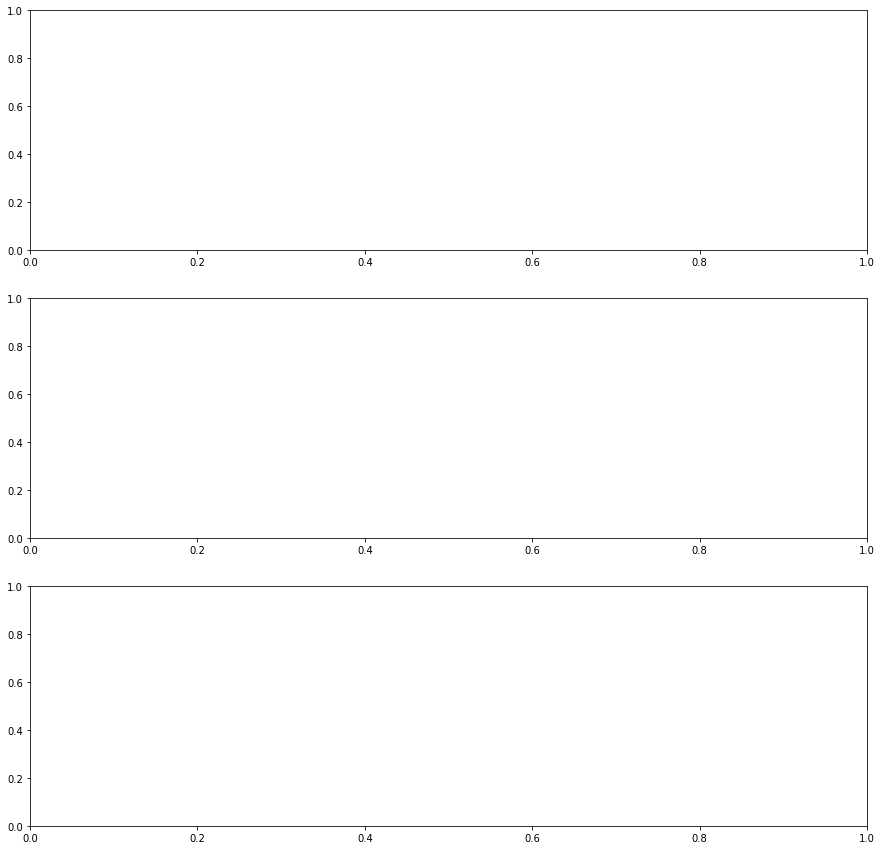

In [77]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# title = "Learning Curves (5 layer MLP)"
# clf1 = MLPClassifier(alpha=0.0005, hidden_layer_sizes=(5,), solver='lbfgs', max_iter=10000, random_state=18, early_stopping=True)
# clf1.fit(scaled_train_X, train_y)
# print (clf1.score(scaled_train_X,train_y))
# print(f"Testing accuracy score: {100* accuracy_score(test_y, clf1.predict(scaled_test_X))}%")
# plt.plot(clf1.validation_scores_)

# title = "Learning Curves (10 layer MLP)"
# clf2 = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10,), solver='lbfgs', max_iter=10000, random_state=18, early_stopping=True)
# clf1.fit(scaled_train_X, train_y)
# print (clf1.score(scaled_train_X,train_y))
# print(f"Testing accuracy score: {100* accuracy_score(test_y, clf1.predict(scaled_test_X))}%")
# plt.plot(clf1.validation_scores_)

# title = "Learning Curves (15 layer MLP)"
# clf3 = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(15,), solver='lbfgs', max_iter=10000, random_state=18, early_stopping=True)
# clf3.fit(train_X, train_y)
# plt.subplot(clf3.loss_curve_)
# plot_learning_curve(clf3, title, train_X, train_y, axes=axes[2,:], ylim=(0.7, 1.01), cv=cv, n_jobs=4)


# plt.show()



### Boosting

In [57]:
n_learning_rate_steps, n_folds = 10, 3
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))
stump = DecisionTreeClassifier(max_depth=1, random_state = 100)
 
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump, 
                                   n_estimators=10, learning_rate=rate)
        model.fit(train_X.values[trn, :], train_y.values[trn])
        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], model.predict(train_X.values[val, :]))
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)
print(f'Training Error {trn_err}, Value Error {val_err}')


Training Error [0.51927004 0.5071465  0.50803982 0.51033691 0.51429301 0.49974477
 0.53905054 0.53330781 0.58486473 0.53828484], Value Error [0.52092905 0.51352731 0.52092905 0.51837672 0.51531394 0.51352731
 0.54211332 0.539561   0.58448188 0.55028076]


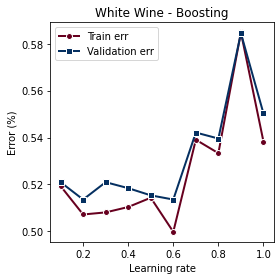

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_title("White Wine - Boosting")
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [66]:
n_estimator_steps, n_folds = 2, 3
number_of_stumps = np.arange(2,125, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_acc = np.zeros((len(number_of_stumps), n_folds))
val_acc = np.zeros((len(number_of_stumps), n_folds))
test_acc = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump,
                                   n_estimators=n_stumps, learning_rate=0.6)
        model.fit(train_X.values[trn, :], train_y.values[trn])

        trn_acc[i, j] = accuracy_score(train_y.values[trn], 
                                           model.predict(train_X.values[trn, :]))
        val_acc[i, j] = accuracy_score(train_y.values[val], 
                                           model.predict(train_X.values[val, :]))
        test_acc[i,j] = accuracy_score(test_y, model.predict(test_X))
        

trn_acc = np.mean(trn_acc, axis=1)
val_acc = np.mean(val_acc, axis=1)
test_acc = np.mean(test_acc, axis=1)

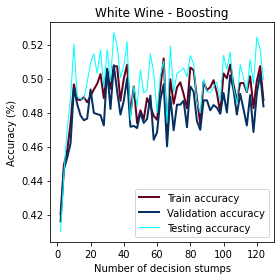

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_acc, c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_acc, c=cm[1], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, test_acc, c="cyan", markeredgecolor='w', linewidth=1)
ax.legend(['Train accuracy', 'Validation accuracy', "Testing accuracy"])
ax.set_title("White Wine - Boosting")
ax.set_xlabel('Number of decision stumps')
ax.set_ylabel('Accuracy (%)')

fig.tight_layout()

In [62]:
shallow_tree = DecisionTreeClassifier(max_depth=1)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, 
                                  n_estimators=125, learning_rate=0.6)
ensemble.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.6, n_estimators=125)

In [63]:
ypred = ensemble.predict(test_X)
acc = accuracy_score(test_y, ypred)
acc

0.32040816326530613

### SVM

In [ ]:
fig, axes = plt.subplots(6, 3, figsize=(15, 30))

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

title = "Learning Curves (C5 layer MLP) kernel=rbf"
clf1 = svm.SVC(kernel='rbf', C=15, gamma='auto')
clf1.fit(train_X, train_y)
plot_learning_curve(clf1, title, train_X, train_y, axes=axes[0, :], ylim=(0.2, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (C30 layer MLP) kernel=rbf"
clf2 = svm.SVC(kernel='rbf', C=30, gamma='auto')
clf2.fit(train_X, train_y)
plot_learning_curve(clf2, title, train_X, train_y, axes=axes[1,:], ylim=(0.2, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (C45 layer MLP) kernel=rbf"
clf3 = svm.SVC(kernel='rbf', C=45, gamma='auto')
clf3.fit(train_X, train_y)
plot_learning_curve(clf3, title, train_X, train_y, axes=axes[2,:], ylim=(0.2, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (C5 layer MLP) kernel=poly"
clf4  = svm.SVC(kernel='poly', C=15, gamma='auto')
clf4.fit(train_X, train_y)
plot_learning_curve(clf4, title, train_X, train_y, axes=axes[3, :], ylim=(0.2, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (C30 layer MLP) kernel=poly"
clf5 = svm.SVC(kernel='poly', C=30, gamma='auto')
clf5.fit(train_X, train_y)
plot_learning_curve(clf5, title, train_X, train_y, axes=axes[4,:], ylim=(0.2, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (C45 layer MLP) kernel=poly"
clf6 = svm.SVC(kernel='poly', C=45, gamma='auto')
clf6.fit(train_X, train_y)
plot_learning_curve(clf6, title, train_X, train_y, axes=axes[5,:], ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
print(f'Best Score - C5 rbf: {clf1.score(test_X, test_y)*100:.2f}%')
print(f'Best Score - C30 rbf: {clf2.score(test_X, test_y)*100:.2f}%')
print(f'Best Score - C45 rbf: {clf3.score(test_X, test_y)*100:.2f}%')
print(f'Best Score - C5 poly: {clf4.score(test_X, test_y)*100:.2f}%')
print(f'Best Score - C30 poly: {clf5.score(test_X, test_y)*100:.2f}%')
print(f'Best Score - C45 poly: {clf6.score(test_X, test_y)*100:.2f}%')

In [74]:
import time

kernelList = ['rbf','poly']
CList = [0.1, 1, 3, 10]
degreeList = [1,2,3]
gammaList = [0.01,0.1,1.0]

for i,kernel in enumerate(kernelList):
    for j,c in enumerate(CList):
        if kernel=='poly':
            for l,degree in enumerate(degreeList):
                clf = svm.SVC(kernel=kernel, C=c, degree=degree, cache_size=400)
                
                start=time.process_time()
                clf.fit(train_res_X, train_res_y)
                fitTime = time.process_time() - start
                
                testValue = clf.score(train_res_X, train_res_y)*100
                trainValue = clf.score(test_X, test_y)*100 
                
                start = time.process_time()
                clf.predict(test_X)
                testTime = time.process_time() - start
                print(f'SVM: {kernel}, {degree}, {c}, {fitTime:.2f}s, {trainValue:.2f}%, {testTime:.2f}s, {testValue:.2f}%')   
        if kernel=='rbf':
            for l,gamma in enumerate(gammaList):
                clf  = svm.SVC(kernel=kernel, C=c, gamma=gamma, cache_size=400)                                
                
                start=time.process_time()
                clf.fit(train_X, train_y)
                fitTime = time.process_time() - start
                
                testValue = clf.score(train_X, train_y)*100
                trainValue = clf.score(test_X, test_y)*100 
                
                start = time.process_time()
                clf.predict(test_X)
                testTime = time.process_time() - start

                print(f'SVM: {kernel}, {gamma}, {c}, {fitTime:.2f}s, {trainValue:.2f}%, {testTime:.2f}s, {testValue:.2f}%')

SVM: rbf, 0.01, 0.1, 0.71s, 46.53%, 0.09s, 47.09%
SVM: rbf, 0.1, 0.1, 1.08s, 46.12%, 0.10s, 44.56%
SVM: rbf, 1.0, 0.1, 1.04s, 46.12%, 0.09s, 44.56%
SVM: rbf, 0.01, 1, 0.71s, 48.47%, 0.08s, 56.58%
SVM: rbf, 0.1, 1, 1.26s, 58.67%, 0.10s, 83.44%
SVM: rbf, 1.0, 1, 1.27s, 62.96%, 0.09s, 99.46%
SVM: rbf, 0.01, 3, 0.77s, 51.02%, 0.08s, 63.65%
SVM: rbf, 0.1, 3, 1.35s, 60.41%, 0.09s, 94.74%
SVM: rbf, 1.0, 3, 1.22s, 63.27%, 0.08s, 99.92%
SVM: rbf, 0.01, 10, 0.90s, 52.96%, 0.08s, 71.31%
SVM: rbf, 0.1, 10, 1.45s, 61.84%, 0.09s, 99.13%
SVM: rbf, 1.0, 10, 1.25s, 63.37%, 0.08s, 99.97%
SVM: poly, 1, 0.1, 4.71s, 15.20%, 0.17s, 30.72%
SVM: poly, 2, 0.1, 4.71s, 13.78%, 0.16s, 30.13%
SVM: poly, 3, 0.1, 5.24s, 13.37%, 0.17s, 29.49%
SVM: poly, 1, 1, 4.93s, 17.65%, 0.16s, 37.14%
SVM: poly, 2, 1, 5.12s, 17.14%, 0.16s, 40.48%
SVM: poly, 3, 1, 5.69s, 17.96%, 0.18s, 41.52%
SVM: poly, 1, 3, 5.63s, 20.41%, 0.18s, 41.49%
SVM: poly, 2, 3, 5.38s, 19.29%, 0.17s, 43.68%
SVM: poly, 3, 3, 6.13s, 19.69%, 0.17s, 45.21%
SVM

### KNN

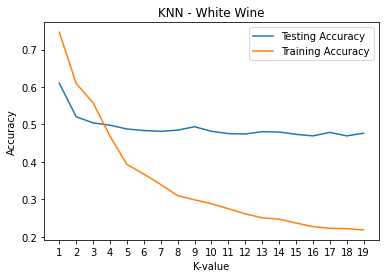

Maximum KNN Score is 61.02% at 1 neighbors


In [76]:
scoreList = []
neighbors = np.arange(1,20)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn2 = KNeighborsClassifier(n_neighbors = k)  # n_neighbors means k
    knn2.fit(train_X, train_y)
    # plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (f'# Nodes: {i}', auc))
    #Compute accuracy on the training set 
    train_accuracy[i] = knn2.score(train_res_X, train_res_y) 
    #Compute accuracy on the test set 
    test_accuracy[i] = knn2.score(test_X, test_y) 

plt.title('KNN - White Wine')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
# plt.plot(neighbors, scoreList)
plt.xticks(neighbors)
plt.legend()
plt.xlabel("K-value")
plt.ylabel("Accuracy")
plt.show()

acc = max(test_accuracy)*100
key = np.argmax(test_accuracy) + 1
print(f'Maximum KNN Score is {acc:.2f}% at {key} neighbors')